In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Problem : Principal Component Analysis
**Principal component analysis** (PCA) is a technique of dimensionality reduction, which linearly maps data onto a lower-dimensional space, so that the variance of the projected data in the associated dimensions would be maximized. In this problem, you will perform PCA on a dataset of face images.

In [2]:
num_person = 40
num_pic = 10
x_train = []
y_train = []
x_test = []
y_test = []

# 第十筆當test
for i_person in range(1, num_person+1):
    for i_pic in range(1, num_pic+1):
        image = cv2.imread(f"data/{i_person}_{i_pic}.png",
                           flags=cv2.IMREAD_GRAYSCALE)
        image_shape = image.shape
        image = image.ravel()
        if i_pic == 10:
            x_test.append(image)
            y_test.append(i_person)
        else:
            x_train.append(image)
            y_train.append(i_person)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)

(360, 2576)
(40, 2576)


## 1. mean face & first four eigenfaces

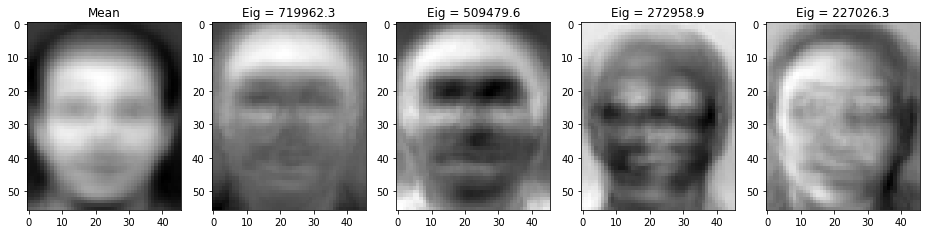

In [3]:
# default n_components = min(n_sample, n_feature)
pca = PCA(n_components=360)
projected_x_train = pca.fit_transform(x_train)
plt.figure(num=1, figsize=(16, 12))
plt.subplot(1, 5, 1)
plt.title("Mean")
plt.imshow(pca.mean_.reshape(image_shape), cmap='gray')

# pca.components_ is eignevectors (each shape = (1, n_feature))
# its shape = (n_components, n_feature)
# plot the first 4 principal axes
for i_eig in range(4):
    eigen_face = pca.components_[i_eig]
    plt.subplot(1, 5, i_eig+2)
    plt.title(f"Eig = {pca.explained_variance_[i_eig]:^.1f}")
    plt.imshow(eigen_face.reshape(image_shape), cmap='gray')

## 2. Reconstruct person2 image1 using the first n = 3, 50, 170, 240, 345 eigenfaces
## 3. compute the mean squared error

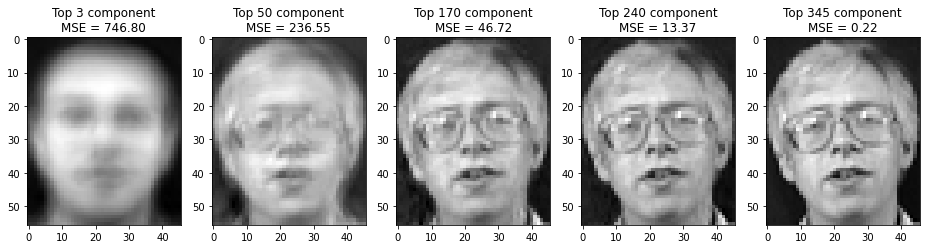

In [4]:
image_2_1 = cv2.imread(f"data/2_1.png",
                       flags=cv2.IMREAD_GRAYSCALE)
image_2_1 = image_2_1.reshape(1, -1)
# mapping image_2_1 to principal axes
projected_image_2_1 = pca.transform(image_2_1)
# This is equivalent to
# projected_image_2_1 = (image_2_1 - pca.mean_).dot(pca.components_.T)

# Testing on inverse mapping
plt.figure(num=2, figsize=(16, 12))
num_component_list = [3, 50, 170, 240, 345]
for i, n in enumerate(num_component_list):
    eigen_face = np.zeros(image_shape[0]*image_shape[1])
    for i_eigen in range(n):
        eigen_face += projected_image_2_1[0,
                                          i_eigen]*pca.components_[i_eigen, :]
    eigen_face += pca.mean_
    mse = ((eigen_face - image_2_1)**2).mean()
    plt.subplot(1, len(num_component_list), i+1)
    plt.title(f"Top {n} component\nMSE = {mse:^.2f}")
    plt.imshow(eigen_face.reshape(image_shape), cmap='gray')
plt.show()

## 4. cross-validation results

In [5]:
k_list = [1, 3, 5]  # k nearest neighbors for KNN
n_list = [3, 50, 170]  # n dimemsion for PCA

shuffling = np.random.permutation(y_train.size)
shuffled_y_train = y_train[shuffling]
shuffled_projected_x_train = projected_x_train[shuffling, :]
for k in k_list:
    print(f"k = {k}")
    model = KNeighborsClassifier(
        n_neighbors=k, p=2, weights="distance", algorithm="brute")
    for n in n_list:
        # train with top n reduced features
        scores = cross_val_score(
            model, shuffled_projected_x_train[:, :n], shuffled_y_train, cv=5)
        print(f"\tn = {n}, score = {scores.mean()}")

k = 1
	n = 3, score = 0.7333333333333334
	n = 50, score = 0.9833333333333334
	n = 170, score = 0.975
k = 3
	n = 3, score = 0.7194444444444443
	n = 50, score = 0.95
	n = 170, score = 0.9555555555555555
k = 5
	n = 3, score = 0.6916666666666667
	n = 50, score = 0.9472222222222222
	n = 170, score = 0.925


## 5. recognition rate of the testing set

In [6]:
# choose k=1, n=50

k = 1
n = 50
projected_x_test = pca.transform(x_test)
model = KNeighborsClassifier(
    n_neighbors=k, p=2, weights="distance", algorithm="brute")
model.fit(projected_x_train[:, :n], y_train)

y_pred = model.predict(projected_x_test[:, :n])
print(f"Accurracy: {accuracy_score(y_test, y_pred)}")

Accurracy: 0.925
